In [1]:
## Mammoth example
# Read in csv
import os
import pandas as pd

mammoth_file = "./input_data_test/mammoth_a.csv"

df_mammoth = pd.read_csv(mammoth_file)
## Sample rows 
n_samples = 2000
df_mammoth = df_mammoth.sample(n=n_samples, random_state=42)

# KMeans clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(df_mammoth[['x', 'y', 'z']])
df_mammoth['Cluster'] = [f'Cluster_{i+1}' for i in cluster_labels]

# Create annotation dataframe
df_mammoth.index = [f"sample_{i}" for i in range(len(df_mammoth))]
df_mammoth_anno = pd.DataFrame({
	'sample_id': df_mammoth.index,
	'Cluster': df_mammoth['Cluster'].values
})
df_mammoth_anno.set_index('sample_id', inplace=True)

## Plot in 3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_mammoth['x'], df_mammoth['y'], df_mammoth['z'],
					 c=cluster_labels, cmap='tab10', s=30, alpha=0.5)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot of Mammoth Data (KMeans Clusters)')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

# Save as parquet with fake sample id per row
output_file = "./input_data_test/mammoth_a.parquet"
df_mammoth.drop(columns=['Cluster']).to_parquet(output_file)

# Save annotations
anno_file = "./input_data_test/mammoth_a_annotations.parquet"
df_mammoth_anno.to_parquet(anno_file)

FileNotFoundError: [Errno 2] No such file or directory: './input_data_test/mammoth_a.csv'

In [2]:
df_mammoth.columns

Index(['x', 'y', 'z', 'Cluster'], dtype='object')

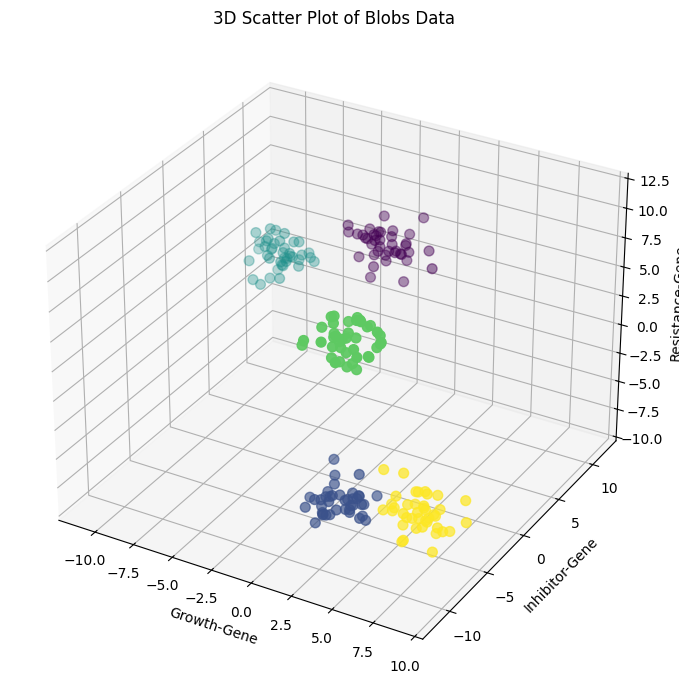

In [2]:
## Generate mock data via sklearn 
from sklearn import datasets
n_samples = 200
seed = 42
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed, n_features=3, centers=5, cluster_std=1.0)

## Make 3D plot of the data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(blobs[0][:, 0], blobs[0][:, 1], blobs[0][:, 2], c=blobs[1], cmap='viridis', s=50)
ax.set_xlabel('Growth-Gene')
ax.set_ylabel('Inhibitor-Gene')
ax.set_zlabel('Resistance-Gene')
plt.title('3D Scatter Plot of Blobs Data')
plt.tight_layout()
plt.show()

## Save the data to a parquet file
import pandas as pd
df = pd.DataFrame(blobs[0], columns=['Growth-Gene', 'Inhibitor-Gene', 'Resistance-Gene'])
df.index = [f'Patient_{i}' for i in range(n_samples)]
df.to_parquet('blobs_data.parquet', index=True)
## Save second blobs annotation file
df_annotations = pd.DataFrame({'Cluster': [f'Cluster_{label+1}' for label in blobs[1]]})
df_annotations.index = df.index
df_annotations.to_parquet('blobs_annotations.parquet', index=True)

In [4]:
## Data input
import os
from autoencodix.configs.default_config import DataConfig, DataInfo, DefaultConfig
from autoencodix.configs.default_config import DataCase

root_dir = os.path.join("./")
gene_expression_file = "blobs_data.parquet"
anno_file = "blobs_annotations.parquet"

## Config definition
my_config_blob = DefaultConfig(
	data_case=DataCase.MULTI_BULK,
	k_filter=3,
	epochs=100,
	learning_rate=0.001,
	n_layers=1,
	latent_dim=2,
	batch_size=16,
	beta = 0.01,
    checkpoint_interval=1,
    data_config=DataConfig(
        data_info={
            "EXPRESSION": DataInfo(file_path=os.path.join(root_dir, gene_expression_file), scaling="STANDARD"),
            "ANNO": DataInfo(
                file_path=os.path.join(root_dir, anno_file), data_type="ANNOTATION",
				
            ),
        }
    )
)

# Mammoth example
# mammoth_data_file = "./input_data_test/mammoth_a.parquet"
# mammoth_anno_file = "./input_data_test/mammoth_a_annotations.parquet"
# my_config_mammoth = DefaultConfig(
# 	data_case=DataCase.MULTI_BULK,
# 	k_filter=3,
# 	epochs=100,
# 	learning_rate=0.005,
# 	latent_dim=2,
# 	batch_size=256,
# 	n_layers=1,
# 	beta = 0.001,
#     checkpoint_interval=1,
#     data_config=DataConfig(
#         data_info={
#             "EXPRESSION": DataInfo(file_path=os.path.join(root_dir, mammoth_data_file), scaling="STANDARD"),
# 			"ANNO": DataInfo(
#                 file_path=os.path.join(root_dir, mammoth_anno_file), data_type="ANNOTATION",
#             ),
#         }
#     )
# )


In [5]:
## Run autoencoder training
import autoencodix as acx

# var = acx.Varix(config=my_config_mammoth)
# var = acx.Vanillix(config=my_config_mammoth)

var = acx.Varix(config=my_config_blob)
# var = acx.Vanillix(config=my_config_blob)



var.run()

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:189: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.varix_config.VarixConfig'> work best
  warnings.warn(


bulk_dfs keys in process_multi_bulk: dict_keys(['EXPRESSION'])
--- Running Pairing-Aware Split ---
Identified 200 fully paired samples across all modalities.
Identified 0 samples present in at least one, but not all, modalities.
Successfully generated synchronized indices for all modalities.
cur shape: EXPRESSION: (140, 3)
cur shape: EXPRESSION: (40, 3)
cur shape: EXPRESSION: (20, 3)
Epoch 1 - Train Loss: 481.2075
Sub-losses: recon_loss: 481.2075, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 61.4036
Sub-losses: recon_loss: 61.4036, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 472.6849
Sub-losses: recon_loss: 472.6849, var_loss: 0.0000, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 2 - Valid Loss: 54.3326
Sub-losses: recon_loss: 54.3326, var_loss: 0.0000, anneal_factor: 0.0001, effective_beta_factor: 0.0000
Epoch 3 - Train Loss: 456.2769
Sub-losses: recon_loss: 456.2769, var_loss

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: VarixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x3355e4220>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x122166ef0>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x3355e7610>)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 40 × 2
    uns: 'var_names'
final_reconstruction: <aut

Creating plots ...


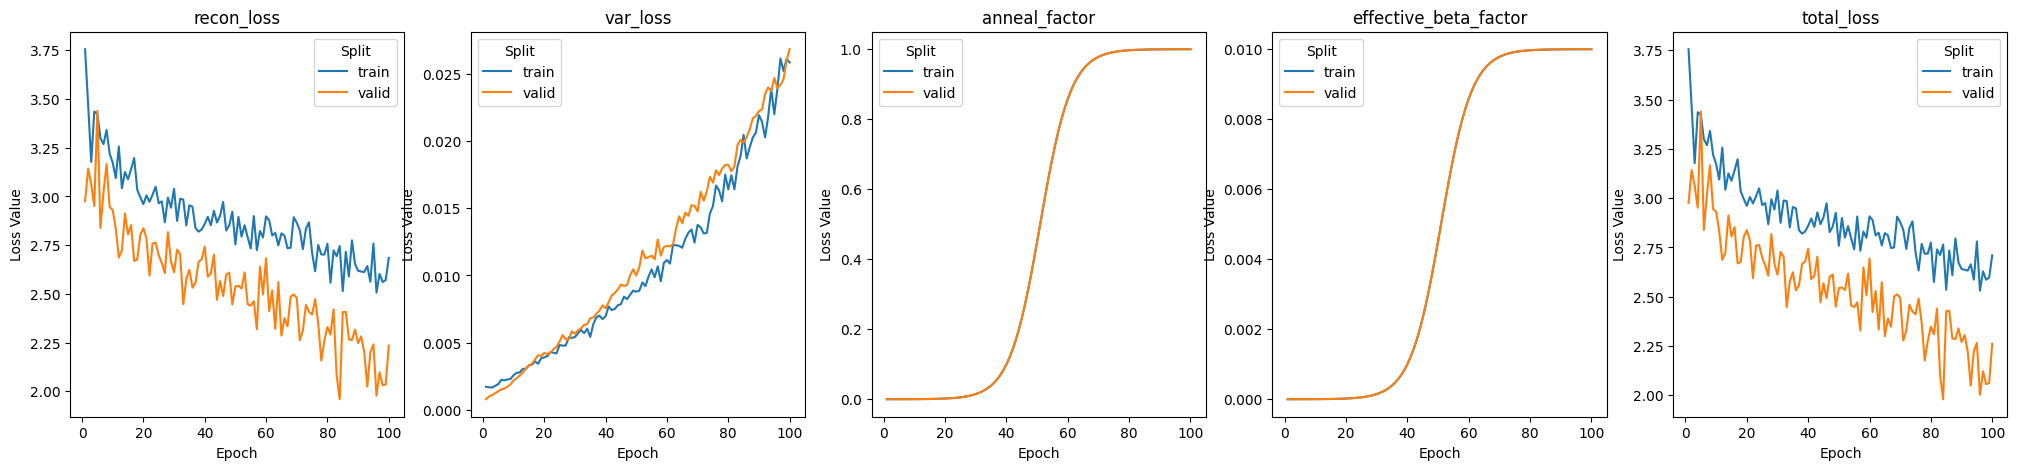

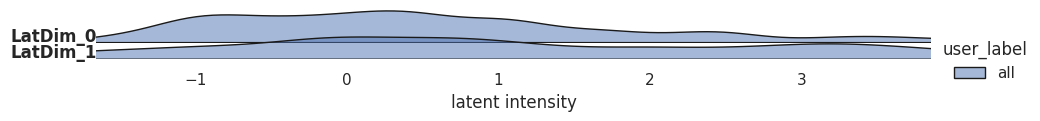

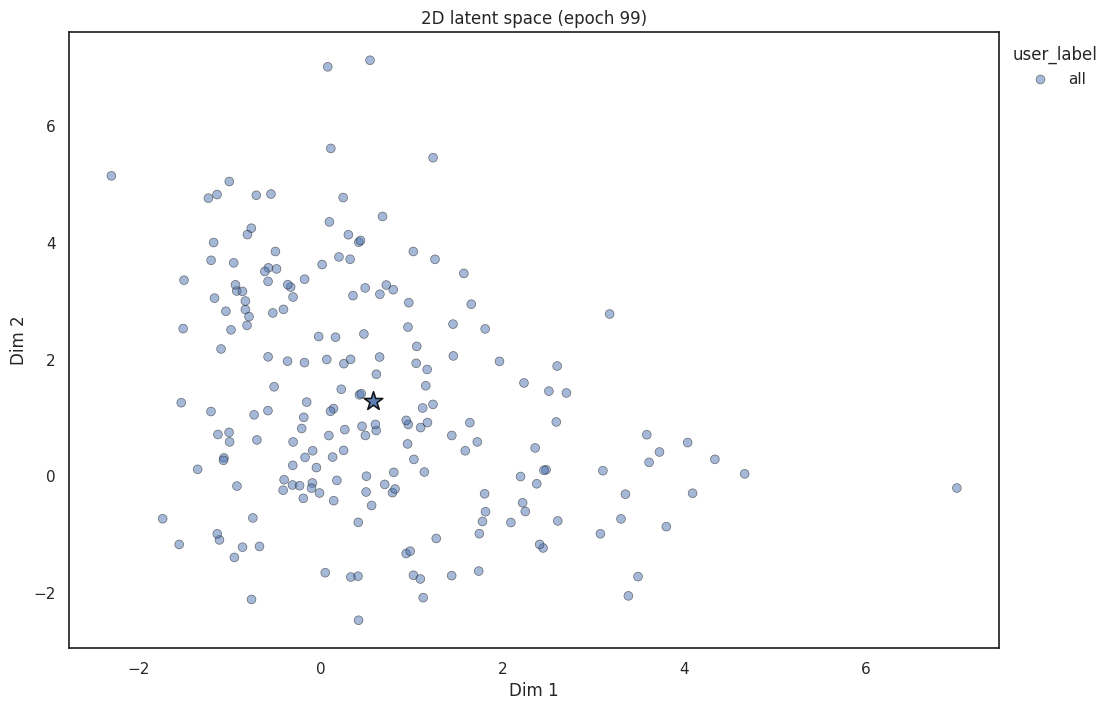

In [6]:
## Check result plots
var.show_result()

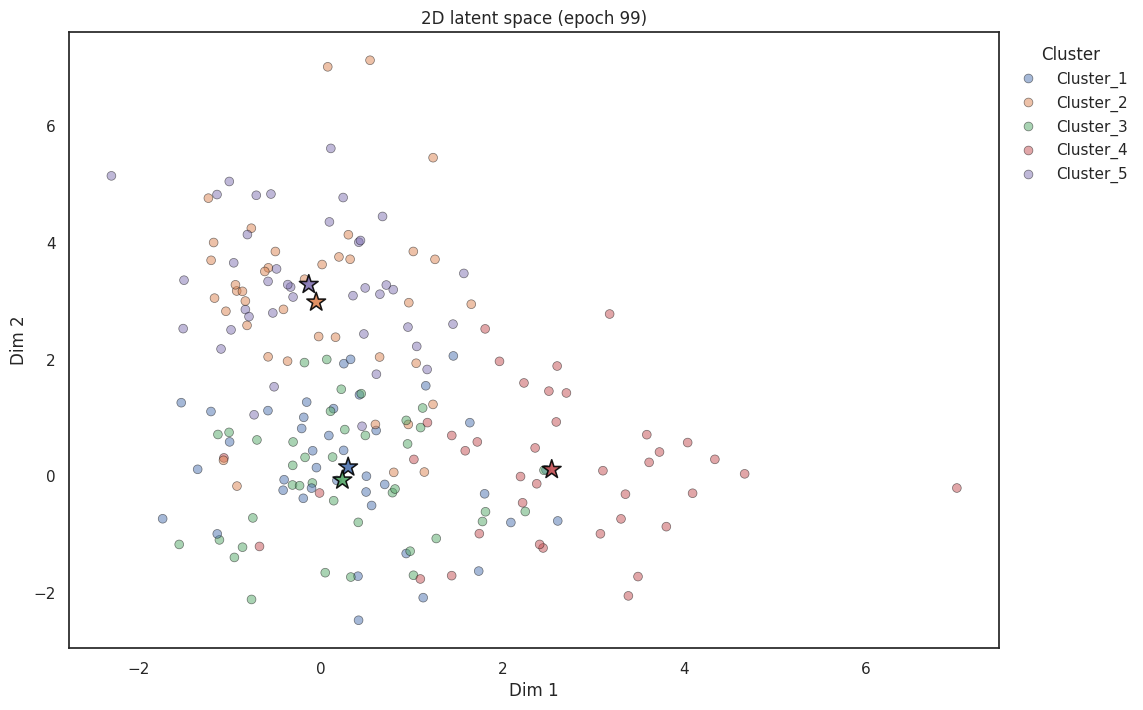

In [7]:
var._visualizer.show_latent_space(result=var.result, plot_type='2D-scatter', param=["Cluster"])

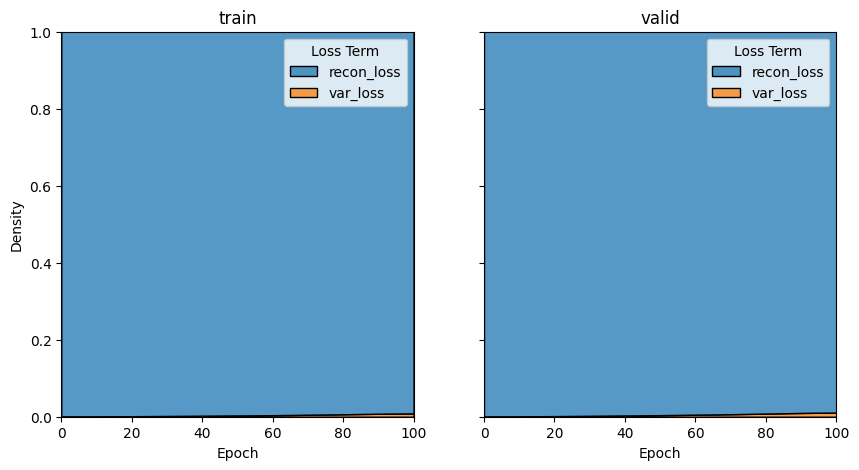

In [8]:
var._visualizer.show_loss(plot_type="relative")

In [6]:
result = var.result
l1 = result.get_latent_df(split="train", epoch=1)
l2 = result.get_latent_df(split="train", epoch=2)
l1.head()

,LatDim_0,LatDim_1
Patient_0,-1.177034,0.762296
Patient_1,-1.252591,-0.007946
Patient_10,-1.567582,-0.369013
Patient_100,0.112016,1.073125
Patient_102,-1.471190,0.277054


In [7]:
l2.head()

,LatDim_0,LatDim_1
Patient_0,2.768160,0.845670
Patient_1,1.268079,-1.752332
Patient_10,0.146766,-0.798359
Patient_100,2.664481,1.256455
Patient_102,2.629382,-0.653823


In [9]:
var.result.model

VarixArchitecture(
  (_encoder): Sequential(
    (0): Linear(in_features=3, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
  )
  (_mu): Linear(in_features=2, out_features=2, bias=True)
  (_logvar): Linear(in_features=2, out_features=2, bias=True)
  (_decoder): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=2, out_features=3, bias=True)
  )
)

In [1]:
input_df = pd.concat([
	var._datasets.train._to_df(),
	var._datasets.test._to_df(),
	var._datasets.valid._to_df()
])

## 3D scatter plot of input_df
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(input_df.iloc[:, 0], input_df.iloc[:, 1], input_df.iloc[:, 2],
					s=30, alpha=0.5)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot of Input Data')
plt.show()

NameError: name 'pd' is not defined

In [2]:
# ## Make a UMAP for comparison
# import umap
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler
# # Standardize the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(blobs[0])
# # Fit UMAP
# umap_model = umap.UMAP(n_components=2, random_state=seed)
# X_umap = umap_model.fit_transform(X_scaled)				

# # Plot UMAP results
# plt.figure(figsize=(10, 6))
# plt.scatter(X_umap[:, 0], X_umap[:, 1], c=blobs[1], cmap='viridis', s=50)
# plt.title('UMAP Projection of Blobs Data')
# plt.xlabel('UMAP Component 1')
# plt.ylabel('UMAP Component 2')
# plt.colorbar(label='Cluster')
# plt.tight_layout()
# plt.show()

In [3]:
## Save reconstructions and latent space to csv for each epoch

# Get splits and number of epochs
splits = ["train", "valid"]
n_epochs = var.result.model.config.epochs

output_dir = "./output_alicia"
if not os.path.exists(output_dir):
	os.makedirs(output_dir)

for epoch in range(n_epochs):
	# Collect latent and reconstruction dataframes for all splits
	latent_dfs = []
	recon_dfs = []
	for split in splits:
		latent_df = var.result.get_latent_df(epoch=epoch, split=split)
		recon_df = var.result.get_reconstructions_df(epoch=epoch, split=split)
		latent_df["split"] = split
		recon_df["split"] = split
		latent_dfs.append(latent_df)
		recon_dfs.append(recon_df)
	# Concatenate all splits for this epoch
	latent_all = pd.concat(latent_dfs)
	recon_all = pd.concat(recon_dfs)
	# Save to parquet
	latent_all.to_parquet(f"{output_dir}/latent_epoch_{epoch}.parquet")
	recon_all.to_parquet(f"{output_dir}/reconstructions_epoch_{epoch}.parquet")


NameError: name 'var' is not defined